# Read data

In [2]:
# Import Libraries
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# Define Paths
dataset_dir = "Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 5002
Class: Moderate Dementia, Files Found: 488
Class: Non Demented, Files Found: 67222
Class: Very mild Dementia, Files Found: 13725


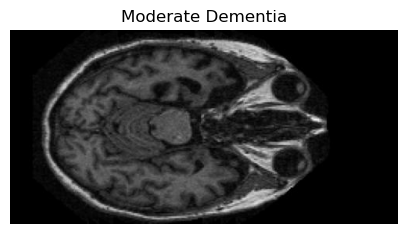

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and plot an image
img = mpimg.imread(image_paths[5002])
plt.figure(figsize=(5, 5))
plt.title(classes[labels[5002]])
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()


In [6]:
# Split Dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}, Testing images: {len(test_paths)}")

Total images: 86437
Training images: 69149, Testing images: 17288


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

# Normalize image paths and labels
train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

# One-hot encode the labels
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.transform(test_labels)

# Preprocessing Function for Images
IMG_HEIGHT, IMG_WIDTH = 224, 224

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load Dataset
def load_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset

# Prepare Train and Test Datasets
train_dataset = load_dataset(train_paths, train_labels)
test_dataset = load_dataset(test_paths, test_labels)

# Batch and Shuffle the Datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')  # Number of classes
    ])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [9]:
from tensorflow.keras.optimizers import Adam

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

Epoch 1/10


2025-03-11 20:10:54.886379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [69149,4]
	 [[{{node Placeholder/_1}}]]
2025-03-11 20:10:54.886555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [69149,4]
	 [[{{node Placeholder/_1}}]]
2025-03-11 20:10:55.092889: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2161/2161 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8796

2025-03-11 20:27:17.760068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [17288,4]
	 [[{{node Placeholder/_1}}]]


2161/2161 [==============================] - 1063s 492ms/step - loss: 0.3094 - accuracy: 0.8796 - val_loss: 0.0367 - val_accuracy: 0.9925
Epoch 2/10
2161/2161 [==============================] - 1148s 531ms/step - loss: 0.0746 - accuracy: 0.9697 - val_loss: 0.0105 - val_accuracy: 0.9980
Epoch 3/10
2161/2161 [==============================] - 2283s 1s/step - loss: 0.0456 - accuracy: 0.9828 - val_loss: 0.0079 - val_accuracy: 0.9973
Epoch 4/10
2161/2161 [==============================] - 1180s 546ms/step - loss: 0.0347 - accuracy: 0.9867 - val_loss: 0.0044 - val_accuracy: 0.9988
Epoch 5/10
2161/2161 [==============================] - 1198s 554ms/step - loss: 0.0281 - accuracy: 0.9895 - val_loss: 0.0036 - val_accuracy: 0.9988
Epoch 6/10
2161/2161 [==============================] - 1183s 547ms/step - loss: 0.0257 - accuracy: 0.9904 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 7/10
2161/2161 [==============================] - 1161s 537ms/step - loss: 0.0222 - accuracy: 0.9919 - val_loss: 0

In [10]:
# Save the Model
model.save("alzheimers_detection_model.h5")

541/541 [==============================] - 66s 122ms/step - loss: 6.7375e-04 - accuracy: 0.9998
Test Loss: 0.0007, Test Accuracy: 0.9998


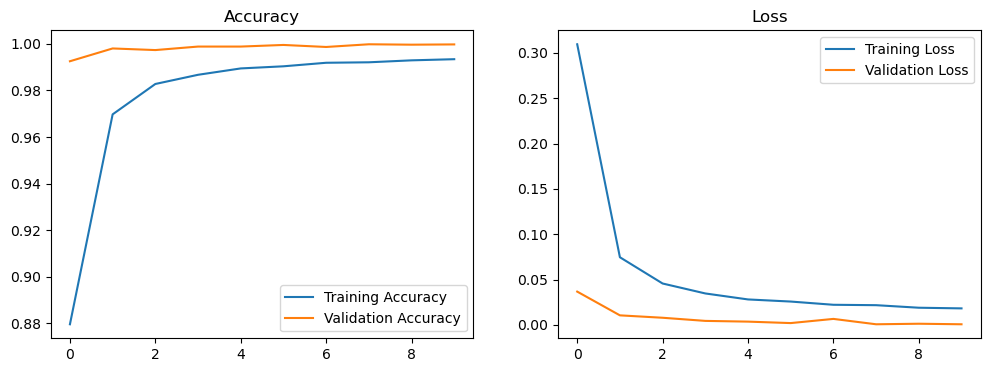

In [11]:
# Plot Accuracy and Loss
import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)

541/541 [==============================] - 67s 123ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00      1000
 Moderate Dementia       1.00      1.00      1.00        98
      Non Demented       1.00      1.00      1.00     13445
Very mild Dementia       1.00      1.00      1.00      2745

          accuracy                           1.00     17288
         macro avg       1.00      1.00      1.00     17288
      weighted avg       1.00      1.00      1.00     17288



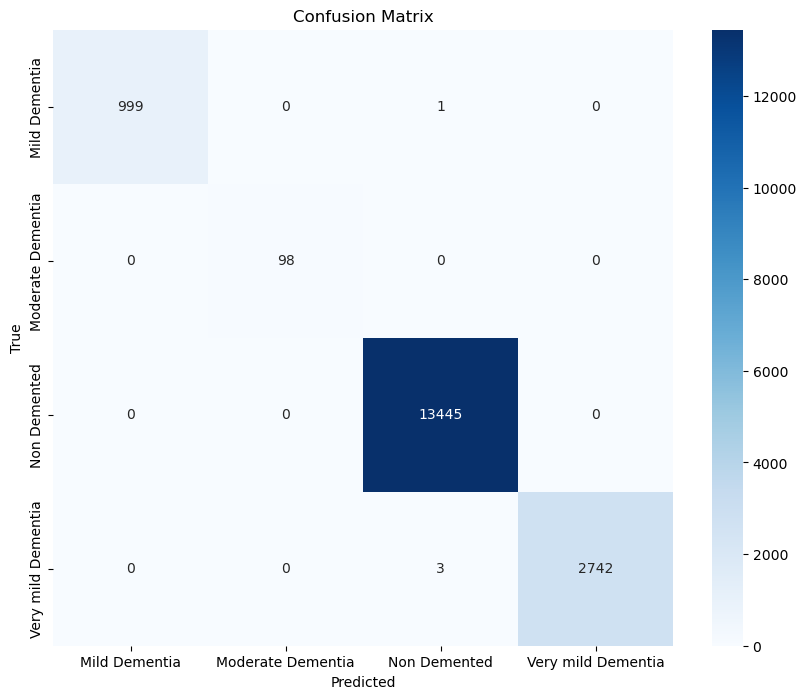

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

y_true = np.argmax(test_labels, axis=1)
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

# Classification Report
class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 [==============================] - 0s 97ms/step
Predicted Class: 1


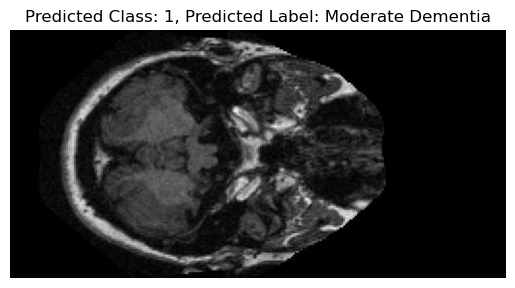

In [15]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Testing on a Single Image
test_image_path = 'Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_105.jpg'
test_image = preprocess_image(test_image_path)
test_image = tf.expand_dims(test_image, axis=0)  # Adding batch dimension

prediction = model.predict(test_image)
predicted_class = label_binarizer.inverse_transform(prediction)[0]
print(f"Predicted Class: {predicted_class}")

if predicted_class==0:
    pred_label="Mild Dementia"
elif predicted_class==1:
    pred_label="Moderate Dementia"
elif predicted_class==2:
    pred_label="Non Demented"
else:
    pred_label="Very Mild Dementia"

# Display Image + Prediction
plt.imshow(plt.imread(test_image_path))
plt.title(f"Predicted Class: {predicted_class}, Predicted Label: {pred_label}")
plt.axis('off')
plt.show()